nr of spikes: 0


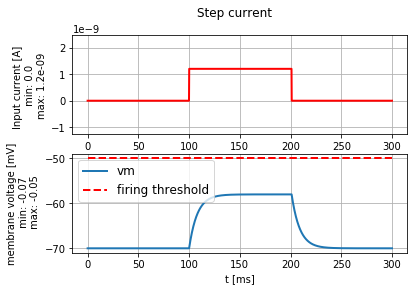

nr of spikes: 5


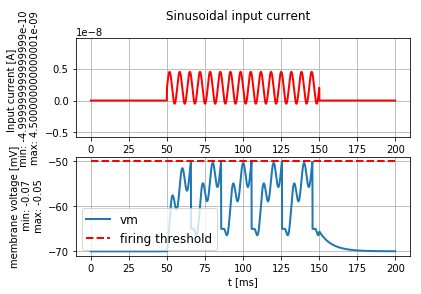

In [1]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex.leaky_integrate_and_fire import LIF
from neurodynex.tools import input_factory, plot_tools

LIF.getting_started()

## Exercise 2.1.1

We have the standard form:

$$\tau \frac{du}{dt} = -(u - u_{rest}) + RI(t)$$

We can rewrite this as:

$$u = u_{rest} + RI(t) - \tau \frac{du}{dt}$$

In the steady state, we have that $\frac{du}{dt} \to 0$. Hence $I = (V_{thresh} - V_{rest}) / R$ will bring the neuron to threshold.

In [5]:
from neurodynex.leaky_integrate_and_fire import LIF
print("resting potential: {}".format(LIF.V_REST))
(LIF.FIRING_THRESHOLD - LIF.V_REST) / LIF.MEMBRANE_RESISTANCE

resting potential: -0.07


2. * namp

## Exercise 2.1.2

Simulation.

nr of spikes: 1


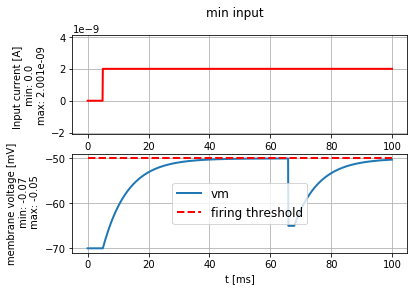

In [9]:
import brian2 as b2
from neurodynex.leaky_integrate_and_fire import LIF
from neurodynex.tools import input_factory

i_min = 2.001*b2.nA

# create a step current with amplitude= i_min
step_current = input_factory.get_step_current(
    t_start=5, t_end=100, unit_time=b2.ms,
    amplitude= i_min)  # set i_min to your value

# run the LIF model.
# Note: As we do not specify any model parameters, the simulation runs with the default values
(state_monitor,spike_monitor) = LIF.simulate_LIF_neuron(input_current=step_current, simulation_time = 100 * b2.ms)

# plot I and vm
plot_tools.plot_voltage_and_current_traces(
state_monitor, step_current, title="min input", firing_threshold=LIF.FIRING_THRESHOLD)
print("nr of spikes: {}".format(spike_monitor.count[0]))  # should be 0

## Exercise 2.2.1

1. I expect a square-root-like IF curve, with saturation
2. The max frequency is 1/3ms = 333Hz 
3. ...

In [12]:
import brian2 as b2
from neurodynex.leaky_integrate_and_fire import LIF
from neurodynex.tools import input_factory

results = []

for i_min in range(100):

    # create a step current with amplitude= i_min
    step_current = input_factory.get_step_current(
        t_start=0, t_end=500, unit_time=b2.ms,
        amplitude= i_min * b2.nA)  # set i_min to your value

    # run the LIF model.
    # Note: As we do not specify any model parameters, the simulation runs with the default values
    (state_monitor,spike_monitor) = LIF.simulate_LIF_neuron(
        input_current=step_current, simulation_time = 500 * b2.ms, abs_refractory_period=3 * b2.ms)

    # plot I and vm
    #plot_tools.plot_voltage_and_current_traces(
    #state_monitor, step_current, title="min input", firing_threshold=LIF.FIRING_THRESHOLD)
    results.append({'current': i_min,
                    'spike_rate': spike_monitor.count[0] * 2})

Text(0, 0.5, 'spike rate (Hz)')

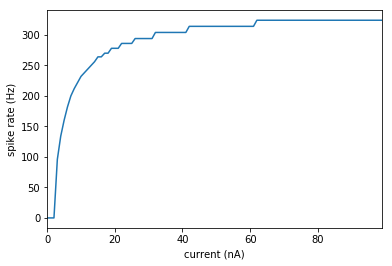

In [18]:
import pandas as pd
df = pd.DataFrame(results).set_index('current')
df.spike_rate.plot()
plt.xlabel('current (nA)')
plt.ylabel('spike rate (Hz)')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f40d406d518>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f40d205be80>)

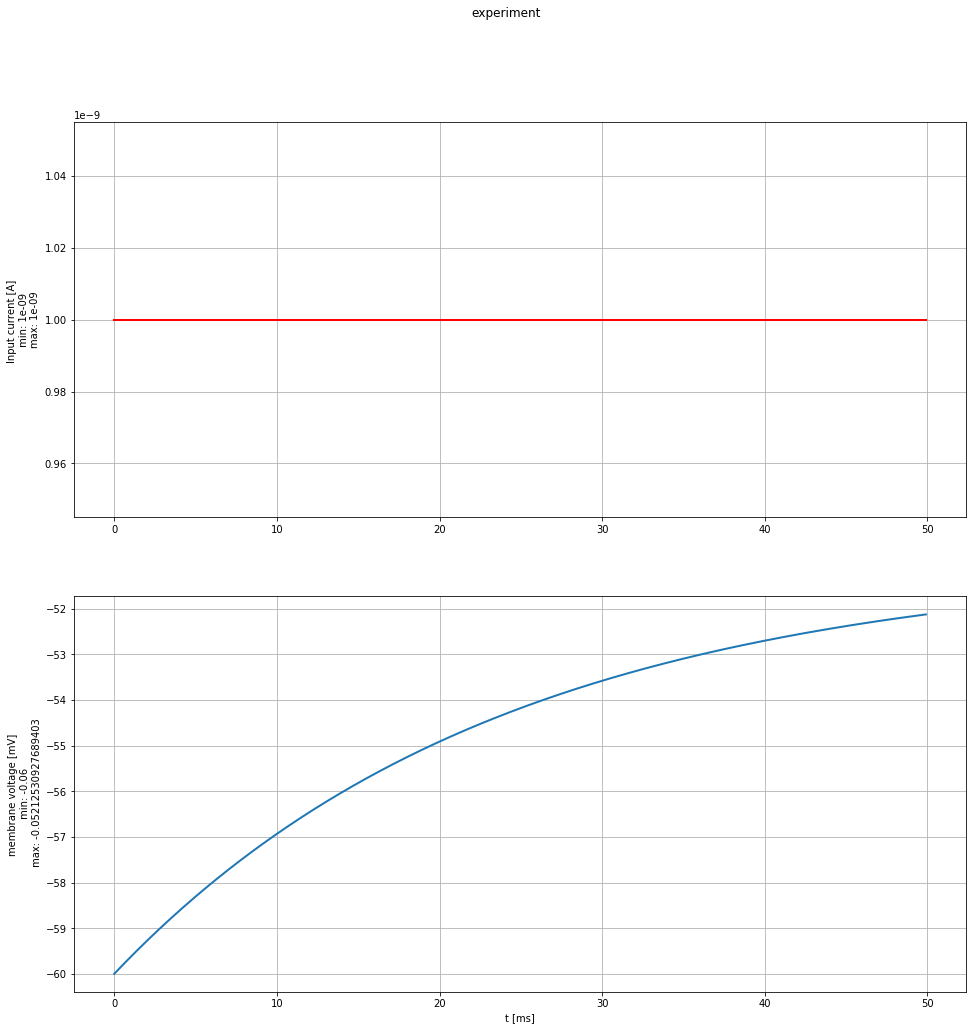

In [30]:
random_parameters = LIF.get_random_param_set(random_seed=432)

# define your test current
test_current = input_factory.get_step_current(
    t_start=0, t_end=1000, unit_time=b2.ms, amplitude= 1 * b2.namp)

# probe the neuron. pass the test current AND the random params to the function
state_monitor, spike_monitor = LIF.simulate_random_neuron(test_current, random_parameters)

# plot
plt.figure(figsize=(16, 16))
plot_tools.plot_voltage_and_current_traces(state_monitor, test_current, title="experiment")

# print the parameters to the console and compare with your estimates
# LIF.print_obfuscated_parameters(random_parameters)

Estimated parameters:

* $V_{rest}$ = -60 mV.
* $V_{reset}$ = -67 mV.
* $V_{thresh}$ = -17 mV
* refractory period: 2 ms
* $\tau$ = 40 ms
* R = 15 M$\Omega$

In [34]:
LIF.print_obfuscated_parameters(random_parameters)

Resting potential: -0.06
Reset voltage: -0.068
Firing threshold: -0.016
Membrane resistance: 9000000.0
Membrane time-scale: 0.024
Absolute refractory period: 0.002


Not too bad

## 2.4 - Sinusoid input, subthreshold.

In [134]:
results = []
for freq in range(10, 1000, 10):
    # note the higher resolution when discretizing the sine wave: we specify unit_time=0.1 * b2.ms
    sinusoidal_current = input_factory.get_sinusoidal_current(200, 1000, unit_time=0.1 * b2.ms,
                                                amplitude= 2.5 * b2.namp, frequency=freq*b2.Hz,
                                                direct_current=0. * b2.namp)

    # run the LIF model. By setting the firing threshold to to a high value, we make sure to stay in the linear (non spiking) regime.
    (state_monitor, spike_monitor) = LIF.simulate_LIF_neuron(input_current=sinusoidal_current, simulation_time = 120 * b2.ms, firing_threshold=0*b2.mV)

    rg = slice(1000 - 256*2, 1000)
    x = sinusoidal_current.values[rg, 0]
    y = np.array(state_monitor.v[0, rg])
    y = y - y.mean()
    fx, fy = np.fft.fft(x), np.fft.fft(y)
    the_freq = np.argmax(abs(fx)[:256])
    g = fy[the_freq] / fx[the_freq]
    phi = np.angle(g)
    g = abs(g)
    results.append({'frequency': freq, 'gain': g, 'phase': phi})


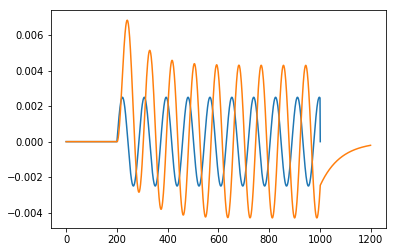

In [113]:
plt.plot(sinusoidal_current.values[:, 0] * 1E6)
plt.plot(np.array(state_monitor.v[0, :]) + .07)

This Bode plot won't win any awards, but...

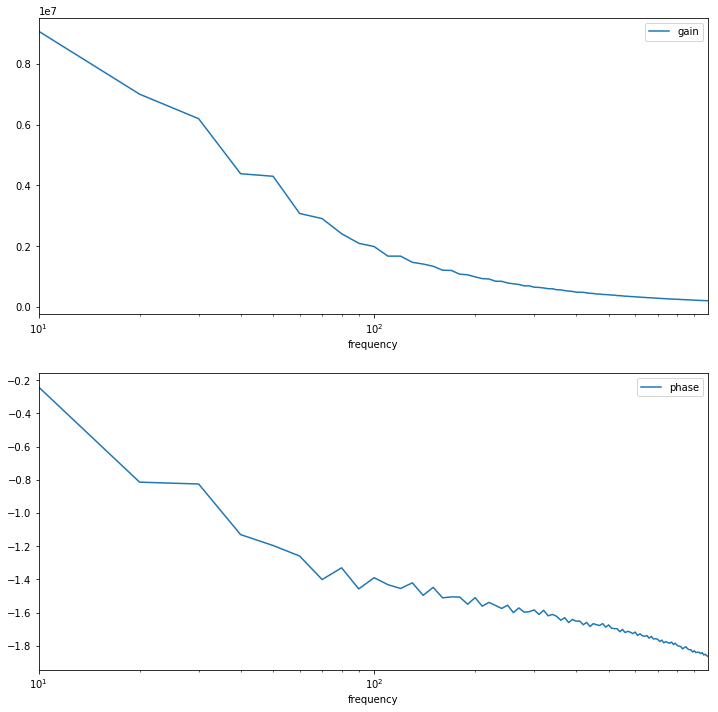

In [135]:
df = pd.DataFrame(results)

plt.figure(figsize=(12, 12))
ax = plt.subplot(211)
df.plot('frequency', 'gain', logx=True, ax=ax)

ax = plt.subplot(212)
df.plot('frequency', 'phase', logx=True, ax=ax)

This is a high-pass filter with the phase growing more retarded with higher frequencies.

## Examine code

In [150]:
!cat $LIF.__file__

"""
This file implements a leaky intergrate-and-fire (LIF) model.
You can inject a step current or sinusoidal current into
neuron using LIF_Step() or LIF_Sinus() methods respectively.

Relevant book chapters:

- http://neuronaldynamics.epfl.ch/online/Ch1.S3.html

"""

# This file is part of the exercise code repository accompanying
# the book: Neuronal Dynamics (see http://neuronaldynamics.epfl.ch)
# located at http://github.com/EPFL-LCN/neuronaldynamics-exercises.

# This free software: you can redistribute it and/or modify it under
# the terms of the GNU General Public License 2.0 as published by the
# Free Software Foundation. You should have received a copy of the
# GNU General Public License along with the repository. If not,
# see http://www.gnu.org/licenses/.

# Should you reuse and publish the code for your own purposes,
# please cite the book or point to the webpage http://neuronaldynamics.epfl.ch.

# Wulfram Gerstner, Werner M. Kistler, Richard Naud, and Liam Paninski.
# Neur

This is the critical code:
    

```
eqs = """
    dv/dt =
    ( -(v-v_rest) + membrane_resistance * input_current(t,i) ) / membrane_time_scale : volt (unless refractory)"""

# LIF neuron using Brian2 library
neuron = b2.NeuronGroup(
    1, model=eqs, reset="v=v_reset", threshold="v>firing_threshold",
    refractory=abs_refractory_period, method="linear")
```